## Setup

Import the required libraries and initialize them:

In [1]:
from std_srvs.srv import Empty, Trigger, TriggerRequest


In [2]:
from cv_bridge import CvBridge, CvBridgeError
import rospy
#import cv2
import ros_numpy
import numpy as np
from tmc_tabletop_segmentator.srv import TabletopSegmentation
from tmc_tabletop_segmentator.srv import TabletopSegmentationRequest
from sensor_msgs.msg import Image
from std_msgs.msg import String
import tf
import tf2_ros
import geometry_msgs.msg
from utils_notebooks import *


the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped
import moveit_commander
import moveit_msgs.msg

import sys

from utils_notebooks import *
#from utils_task1 import *
import cv2
import os

# REMEMBER TO RUN MOVEIT 
# roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [4]:


cv2.__version__

## CHECK  CV VERSIONS IN CASE YOU WONT USE SURF 
## 3.3.1 is an old dependence use sys path remove if needed


'3.3.1-dev'

In [5]:
#! roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [6]:


bridge = CvBridge()
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')
whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
whole_body.set_workspace([-6.0, -6.0, 6.0, 6.0])#whole_body.go(wb)


In [7]:
def rot_to_euler(R):
    import sys
    import math as m
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats

In [8]:
def rot_to_euler(R):
    import sys
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats
def static_tf_publish(cents, quaternions=[],label=''):
    if (len(quaternions))==0:
        quats=np.zeros((len(cents),4)) 
        quats[:,3]=1
        #print quats
    else:
        quats=np.asarray(quaternions)
        #print quats
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan , rejected')
        else:
            #### first place a dissolving tf wrt head sensor  in centroids

            broadcaster.sendTransform((x,y,z),(0,0,0,1), rospy.Time.now(), 'Object'+str(i),"head_rgbd_sensor_link")
            rospy.sleep(.2)
            
            #### then place each centr wrt map
            xyz_map,cent_quat= listener.lookupTransform('/map', 'Object'+str(i),rospy.Time(0))
            map_euler=tf.transformations.euler_from_quaternion(cent_quat)
            rospy.sleep(.2)
            static_transformStamped = TransformStamped()

            ##FIXING TF TO MAP ( ODOM REALLY)    
            #tf_broadcaster1.sendTransform( (xyz[0],xyz[1],xyz[2]),tf.transformations.quaternion_from_euler(0, 0, 0), rospy.Time.now(), "obj"+str(ind), "head_rgbd_sensor_link")
            ## Finally boiradcast a static tf  in cents and with quaternion found  in pca
            if xyz_map[-1] <.2:
                static_transformStamped.header.stamp = rospy.Time.now()
                static_transformStamped.header.frame_id = "map"
                static_transformStamped.child_frame_id = "Floor_Object"+str(i)+label 
                static_transformStamped.transform.translation.x = float(xyz_map[0])
                static_transformStamped.transform.translation.y = float(xyz_map[1])
                static_transformStamped.transform.translation.z = float(xyz_map[2])
                #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
                static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
                static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
                static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
                static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


                tf_static_broadcaster.sendTransform(static_transformStamped)
                print ('images[]',i)
            if    (xyz_map[-1] >.4)and (xyz_map[-1] <.5):
                static_transformStamped.header.stamp = rospy.Time.now()
                static_transformStamped.header.frame_id = "map"
                static_transformStamped.child_frame_id = "Table_Object"+str(i)+label 
                static_transformStamped.transform.translation.x = float(xyz_map[0])
                static_transformStamped.transform.translation.y = float(xyz_map[1])
                static_transformStamped.transform.translation.z = float(xyz_map[2])
                #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
                static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
                static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
                static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
                static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


                tf_static_broadcaster.sendTransform(static_transformStamped)
                print ('images[]',i)
    return True


In [9]:
#!python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation.py

In [10]:
#! python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation_backup.py



In [11]:

rospy.init_node("recognition")


In [12]:
def pose_2_np(wp_p):
   
    return np.asarray((wp_p.pose.position.x,wp_p.pose.position.y,wp_p.pose.position.z)) , np.asarray((wp_p.pose.orientation.w,wp_p.pose.orientation.x,wp_p.pose.orientation.y, wp_p.pose.orientation.z)) 
def np_2_pose(position,orientation):
    wb_p= geometry_msgs.msg.PoseStamped()
    
    wb_p.pose.position.x= position[0]
    wb_p.pose.position.y= position[1]
    wb_p.pose.position.z= position[2]
    wb_p.pose.orientation.w= orientation[0]
    wb_p.pose.orientation.x= orientation[1]
    wb_p.pose.orientation.y= orientation[2]
    wb_p.pose.orientation.z= orientation[3]
    return wb_p

In [13]:
rgbd = RGBD()
#a listener xtion rgbd listener class , (check utils for methods )
# TF is one of the most powerfull underated Ros tools, I recomend to understand it and use it as often as possible.
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()


In [14]:
def gaze_point(x,y,z):
    
    
    
    head_pose = head.get_current_joint_values()
    head_pose[0]=0.0
    head_pose[1]=0.0
    head.set_joint_value_target(head_pose)
    head.go()
    
    trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0)) #
    
    arm_pose=arm.get_current_joint_values()
    arm_pose[0]=.1
    arm_pose[1]= -0.3
    arm.set_joint_value_target(arm_pose)
    arm.go()
    
    e =tf.transformations.euler_from_quaternion(rot)
    print('i am at',trans,np.rad2deg(e)[2])
    print('gaze goal',x,y,z)
    #tf.transformations.euler_from_quaternion(rot)


    x_rob,y_rob,z_rob,th_rob= trans[0], trans[1] ,trans[2] ,  e[2]


    D_x=x_rob-x
    D_y=y_rob-y
    D_z=z_rob-z

    D_th= np.arctan2(D_y,D_x)
    print('relative to robot',(D_x,D_y,np.rad2deg(D_th)))

    pan_correct= (- th_rob + D_th + np.pi) % (2*np.pi)

    if(pan_correct > np.pi):
        pan_correct=-2*np.pi+pan_correct
    if(pan_correct < -np.pi):
        pan_correct=2*np.pi+pan_correct

    if ((pan_correct) > .5 * np.pi):
        print ('Exorcist alert')
        pan_correct=.5*np.pi
    head_pose[0]=pan_correct
    tilt_correct=np.arctan2(D_z,np.linalg.norm((D_x,D_y)))

    head_pose [1]=-tilt_correct
    
    
    
    head.set_joint_value_target(head_pose)
    succ=head.go()
    return succ

In [15]:
clear_octo_client = rospy.ServiceProxy('/clear_octomap', Empty)

clear_octo_client.wait_for_service(timeout=1.0)


In [16]:
# initialize ROS publisher
pub = rospy.Publisher('goal', PoseStamped, queue_size=10)
goal = MoveBaseGoal()
navclient = actionlib.SimpleActionClient('/move_base/move', MoveBaseAction)
    
# wait to establish connection between the navigation interface
# move_base and navigation_log_recorder node
def move_base(goal_x,goal_y,goal_yaw,time_out=10):
    pose = PoseStamped()
    pose.header.stamp = rospy.Time.now()
    pose.header.frame_id = "map"
    pose.pose.position = Point(goal_x, goal_y, 0)
    quat = tf.transformations.quaternion_from_euler(0, 0, goal_yaw)
    pose.pose.orientation = Quaternion(*quat)


    # create a MOVE BASE GOAL
    goal = MoveBaseGoal()
    goal.target_pose = pose

    # send message to the action server
    navclient.send_goal(goal)

    # wait for the action server to complete the order
    navclient.wait_for_result(timeout=rospy.Duration(time_out))

    # print result of navigation
    action_state = navclient.get_state()
    return navclient.get_state()

In [17]:
def seg_pca(lower=2000,higher=50000,reg_ly=0,reg_hy=1000,plt_images=False): 
    image= rgbd.get_h_image()
    iimmg= rgbd.get_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=6
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    _,contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    images=[]
    for i, contour in enumerate(contours):
        
        area = cv2.contourArea(contour)

        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
    
            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            image_aux= iimmg[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[0]+boundRect[2]]
            images.append(image_aux)
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy  ):
                
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY)
                xyz=[]


                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                print (cent)
                points.append(xyz)
            else:
                print ('cent out of region... rejected')
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")

    cents=np.asarray(cents)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points), images)

In [18]:
service_client = rospy.ServiceProxy('/tabletop_segmentator_node/execute', TabletopSegmentation)
service_client.wait_for_service(timeout=1.0)


In [19]:
def res_to_cents(res, plt_images=False):
    objs_depth_centroids=[]
    xyz=[]
    images=[]
    for i in range (len(res.segmented_objects_array.table_objects_array	)):
        print ( 'Plane',i,'has', len(res.segmented_objects_array.table_objects_array[i].depth_image_array), 'objects')
        for j in range (len(res.segmented_objects_array.table_objects_array[i].points_array)):
            cv2_img_depth = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].depth_image_array[0] )
            cv2_img = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].rgb_image_array[j],"rgb8" )
            pc= ros_numpy.numpify (res.segmented_objects_array.table_objects_array[i].points_array[j])
            points=np.zeros((pc.shape[0],3))
            points[:,0]=pc['x']
            points[:,1]=pc['y']
            points[:,2]=pc['z']

            points_mean=np.mean(points,axis=0)
            if np.isnan(points_mean).max():
                print('nan reject')
            else:

                objs_depth_centroids.append(points_mean)
                xyz.append(points)
                images.append(cv2_img)

    print objs_depth_centroids

    #lets publish a tf to this centroids ( lot of false positives) !!!!
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")
    return(np.asarray(objs_depth_centroids), np.asarray(xyz),images)
        

In [22]:
move_base(1.25,1.3,0.5*np.pi)

1

In [23]:
arm.set_named_target('go')
arm.go()
head_val=head.get_current_joint_values()
#head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-45)

head.go(head_val)
#If head didnt move, MOVE IT isnt running  properly

True

In [26]:
objs

NameError: name 'objs' is not defined

In [24]:

#define a tabletop segmentation request.
# Play with these parameters


req = TabletopSegmentationRequest()
req.crop_enabled = True  # limit the processing area
req.crop_x_max = 0.7     # X coordinate maximum value in the area [m]
req.crop_x_min = -0.7    # X coordinate minimum value in the area [m]
req.crop_y_max = 1.0     # Y coordinate maximum value in the area [m]
req.crop_y_min = -1.0    # Y coordinate minimum value in the area [m]
req.crop_z_max = 1.0     # Z coordinate maximum value in the area [m]
req.crop_z_min = -1.0     # Z coordinate minimum value in the area [m]
req.cluster_z_max = 3  # maximum height value of cluster on table [m]
req.cluster_z_min = 0.0  # minimum height value of cluster on table [m]
req.remove_bg = False    # remove the background of the segment image    THIS IS AN IMPORTANT PARAMETER PLEASE NOTICE



In [25]:
def gazebo_2_world(x,y):

    x_world= x+2.1
    y_world= -(y-1.2)
    return (x_world,y_world)

def world_2_gazebo(y_world , x_world):

    x= ( x_world - 2.1)
    y= (-y_world + 1.2) 
    return (x , y)

_path_model = "/home/roboworks/Codes/catkin_mio/src/tmc_wrs_gazebo_world/models"     #Catkin mio version 


objs=os.listdir(_path_model)
objs.sort()


In [26]:
path='/home/roboworks/Videos/videos_to_keras_train/'
obj_ind=-45
obj_name = ''.join(objs[obj_ind].split('_')[1:])
obj_name
try: 
    os.mkdir(path+obj_name) 
except OSError as error: 
    print(error)  
delete_object('spawned')

[Errno 17] File exists: '/home/roboworks/Videos/videos_to_keras_train/040largemarker'


In [27]:
move_base(1.25,1.0,np.pi)
gaze_point(1.25,1.71,.6)

('i am at', [1.3087761550023402, 0.9762122746423411, 0.9671249427960457], 179.5039611073165)
('gaze goal', 1.25, 1.71, 0.6)
('relative to robot', (0.058776155002340236, -0.7337877253576589, -85.42040440335613))


True

In [95]:

x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
eu_i,eu_j,eu_k = 3.1416  ,0,0
spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.41,eu_i,eu_j,eu_k )


[INFO] [1639505884.615587, 12985.474000]: Spawn: ycb_040_large_marker
[INFO] [1639505884.627946, 12985.475000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1639505884.630084, 12985.475000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639505884.649222, 12985.477000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639505884.967492, 12985.487000]: Spawn status: SpawnModel: Successfully spawned entity


[INFO] [1639505885.027287, 12985.491000]: Spawn: ycb_040_large_marker
[INFO] [1639505885.029511, 12985.491000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1639505885.031124, 12985.491000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639505885.038017, 12985.492000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639505885.044280, 12985.492000]: Spawn status: SpawnModel: Failure - entity already exists.
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08277766, 0.1673742 , 0.92035885])]
59
[INFO] [1639505888.048765, 12985.649000]: Spawn: ycb_040_large_marker
[INFO] [1639505888.051219, 12985.649000]: Spawn: [0.         0.         0.99987669 0.01570368]
[INFO] [1639505888.052565, 12985.649000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639505888.062136, 12985.650000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639505888.434939, 12985.666000]: Spawn status: SpawnModel: Successfully spawned entity
('Pl

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10812787, 0.13659985, 0.89689418])]
39
[INFO] [1639506131.429900, 12999.265000]: Spawn: ycb_040_large_marker
[INFO] [1639506131.432329, 12999.265000]: Spawn: [0.         0.         0.97237065 0.23344233]
[INFO] [1639506131.434042, 12999.265000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639506131.437515, 12999.265000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639506131.615688, 12999.268000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10966644, 0.13695035, 0.89630411])]
37
[INFO] [1639506147.554743, 13000.166000]: Spawn: ycb_040_large_marker
[INFO] [1639506147.557330, 13000.166000]: Spawn: [0.         0.         0.96858393 0.2486869 ]
[INFO] [1639506147.559076, 13000.166000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639506147.566363, 13000.167000]: Calling service /gazebo/spawn_sdf_model
[INF

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12242006, 0.14217709, 0.88731576])]
7
[INFO] [1639506391.318891, 13014.341000]: Spawn: ycb_040_large_marker
[INFO] [1639506391.321516, 13014.341000]: Spawn: [0.         0.         0.89100769 0.45398821]
[INFO] [1639506391.323485, 13014.341000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639506391.327134, 13014.342000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639506391.520291, 13014.345000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12288507, 0.1423469 , 0.88609891])]
6
[INFO] [1639506409.330438, 13015.383000]: Spawn: ycb_040_large_marker
[INFO] [1639506409.333030, 13015.383000]: Spawn: [0.         0.         0.88376682 0.46792757]
[INFO] [1639506409.335078, 13015.384000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639506409.339414, 13015.384000]: Calling service /gazebo/spawn_sdf_model
[INFO]

[INFO] [1639506655.311528, 13029.594000]: Spawn: ycb_040_large_marker
[INFO] [1639506655.314038, 13029.594000]: Spawn: [0.         0.         0.76040728 0.64944651]
[INFO] [1639506655.315706, 13029.594000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639506655.318568, 13029.594000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639506655.569640, 13029.601000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12945481, 0.15077727, 0.87221331])]
30
[INFO] [1639506672.385293, 13030.544000]: Spawn: ycb_040_large_marker
[INFO] [1639506672.387461, 13030.544000]: Spawn: [0.         0.         0.75011238 0.66131038]
[INFO] [1639506672.388956, 13030.544000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639506672.396047, 13030.544000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639506672.742779, 13030.557000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'o

[INFO] [1639506923.923276, 13044.707000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12781467, 0.16129339, 0.86048919])]
22
[INFO] [1639506942.721395, 13045.709000]: Spawn: ycb_040_large_marker
[INFO] [1639506942.724052, 13045.709000]: Spawn: [0.         0.         0.57500642 0.81814889]
[INFO] [1639506942.725634, 13045.709000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639506942.730155, 13045.710000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639506942.905109, 13045.711000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12740709, 0.16133726, 0.8588207 ])]
18
[INFO] [1639506961.959906, 13046.731000]: Spawn: ycb_040_large_marker
[INFO] [1639506961.963766, 13046.731000]: Spawn: [0.         0.         0.56208453 0.82707979]
[INFO] [1639506961.966001, 13046.731000]: Waiting for service /gazebo/spawn_

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11955047, 0.1659083 , 0.84673695])]
19
[INFO] [1639507213.679997, 13060.886000]: Spawn: ycb_040_large_marker
[INFO] [1639507213.682693, 13060.886000]: Spawn: [0.         0.         0.36812537 0.92977616]
[INFO] [1639507213.684585, 13060.886000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639507213.702216, 13060.887000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639507213.840319, 13060.888000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11904333, 0.16618358, 0.84614924])]
22
[INFO] [1639507232.528158, 13061.912000]: Spawn: ycb_040_large_marker
[INFO] [1639507232.530589, 13061.912000]: Spawn: [0.         0.         0.35347563 0.93544373]
[INFO] [1639507232.532390, 13061.912000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639507232.536544, 13061.912000]: Calling service /gazebo/spawn_sdf_model
[INF

[INFO] [1639507488.120725, 13076.092000]: Spawn: ycb_040_large_marker
[INFO] [1639507488.123512, 13076.092000]: Spawn: [0.         0.         0.14090156 0.99002361]
[INFO] [1639507488.125233, 13076.092000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639507488.130137, 13076.093000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639507488.276112, 13076.094000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10615546, 0.17042517, 0.83852613])]
61
[INFO] [1639507505.789965, 13077.089000]: Spawn: ycb_040_large_marker
[INFO] [1639507505.793300, 13077.089000]: Spawn: [0.         0.         0.12533353 0.99211466]
[INFO] [1639507505.795041, 13077.089000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639507505.802195, 13077.090000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639507506.154552, 13077.102000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'o

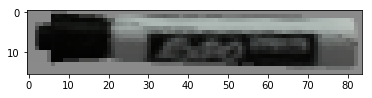

In [96]:

num_imgs=100
for i in range(num_imgs):
    contador=len(os.listdir(path+'/'+obj_name))

    x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
    eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
    spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.45,eu_i,eu_j,eu_k )
    rospy.sleep(.1)
    res = service_client(req)
    cents,xyz, images=res_to_cents(res)
    shapes_ratio=[]
    
    for image in images:
        print(np.abs(image.shape[0]-image.shape[1]))
        shapes_ratio.append(np.abs(image.shape[0]-image.shape[1]))
    if len (images)!=0:
        plt.imshow(images[np.argmin(shapes_ratio)])
        contador=len(os.listdir(path+'/'+obj_name))
        cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[np.argmin(shapes_ratio)], cv2.COLOR_BGR2RGB))
    
    delete_object('spawned')

[INFO] [1639507649.393038, 13085.284000]: Spawn: ycb_040_large_marker
[INFO] [1639507649.396290, 13085.284000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1639507649.399129, 13085.284000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639507649.403611, 13085.284000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639507649.714723, 13085.294000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.0905946 , 0.06663488, 0.85907696])]
63
[INFO] [1639507666.566537, 13086.255000]: Spawn: ycb_040_large_marker
[INFO] [1639507666.569748, 13086.255000]: Spawn: [0.         0.         0.99987669 0.01570368]
[INFO] [1639507666.571890, 13086.256000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639507666.576719, 13086.256000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639507666.746836, 13086.257000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane',

[INFO] [1639507926.456985, 13100.426000]: Spawn: ycb_040_large_marker
[INFO] [1639507926.460544, 13100.426000]: Spawn: [0.         0.         0.97237065 0.23344233]
[INFO] [1639507926.463627, 13100.426000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639507926.478367, 13100.427000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639507926.824938, 13100.446000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10758206, 0.06824318, 0.85607266])]
40
[INFO] [1639507946.239442, 13101.490000]: Spawn: ycb_040_large_marker
[INFO] [1639507946.241996, 13101.490000]: Spawn: [0.         0.         0.96858393 0.2486869 ]
[INFO] [1639507946.243781, 13101.490000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639507946.247480, 13101.490000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639507946.571898, 13101.502000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'o

[INFO] [1639508203.199424, 13115.596000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12092519, 0.07363098, 0.84529416])]
9
[INFO] [1639508220.773966, 13116.586000]: Spawn: ycb_040_large_marker
[INFO] [1639508220.776463, 13116.586000]: Spawn: [0.         0.         0.88376682 0.46792757]
[INFO] [1639508220.778057, 13116.586000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639508220.782905, 13116.587000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639508221.143380, 13116.602000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12149956, 0.07411746, 0.84453436])]
6
[INFO] [1639508238.683678, 13117.580000]: Spawn: ycb_040_large_marker
[INFO] [1639508238.686284, 13117.580000]: Spawn: [0.         0.         0.87630788 0.48175149]
[INFO] [1639508238.687934, 13117.580000]: Waiting for service /gazebo/spawn_sd

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12717494, 0.08141639, 0.82965827])]
25
[INFO] [1639508499.516423, 13131.777000]: Spawn: ycb_040_large_marker
[INFO] [1639508499.519125, 13131.777000]: Spawn: [0.         0.         0.75011238 0.66131038]
[INFO] [1639508499.520626, 13131.777000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639508499.526589, 13131.777000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639508499.704951, 13131.779000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.1273602 , 0.08175917, 0.82884424])]
29
[INFO] [1639508518.671869, 13132.786000]: Spawn: ycb_040_large_marker
[INFO] [1639508518.675378, 13132.786000]: Spawn: [0.         0.         0.73963241 0.67301107]
[INFO] [1639508518.678095, 13132.786000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639508518.716219, 13132.789000]: Calling service /gazebo/spawn_sdf_model
[INF

[INFO] [1639508781.603865, 13146.958000]: Spawn: ycb_040_large_marker
[INFO] [1639508781.606740, 13146.958000]: Spawn: [0.         0.         0.57500642 0.81814889]
[INFO] [1639508781.608278, 13146.958000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639508781.615312, 13146.959000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639508781.793532, 13146.962000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12572413, 0.0898892 , 0.81470019])]
15
[INFO] [1639508801.058341, 13147.982000]: Spawn: ycb_040_large_marker
[INFO] [1639508801.060690, 13147.982000]: Spawn: [0.         0.         0.56208453 0.82707979]
[INFO] [1639508801.062226, 13147.982000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639508801.067266, 13147.983000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639508801.250089, 13147.985000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'o

[INFO] [1639509095.513078, 13162.171000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.1175713 , 0.09711139, 0.80434004])]
24
[INFO] [1639509116.385083, 13163.187000]: Spawn: ycb_040_large_marker
[INFO] [1639509116.387761, 13163.187000]: Spawn: [0.         0.         0.35347563 0.93544373]
[INFO] [1639509116.389536, 13163.187000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639509116.394026, 13163.187000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639509116.575659, 13163.188000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11690264, 0.09743001, 0.80375179])]
28
[INFO] [1639509138.094421, 13164.196000]: Spawn: ycb_040_large_marker
[INFO] [1639509138.097137, 13164.196000]: Spawn: [0.         0.         0.33873868 0.9408805 ]
[INFO] [1639509138.098692, 13164.196000]: Waiting for service /gazebo/spawn_

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10452635, 0.10162407, 0.79752318])]
61
[INFO] [1639509431.366321, 13178.405000]: Spawn: ycb_040_large_marker
[INFO] [1639509431.369059, 13178.405000]: Spawn: [0.         0.         0.12533353 0.99211466]
[INFO] [1639509431.370869, 13178.405000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639509431.382188, 13178.406000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639509431.759612, 13178.419000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10370126, 0.10180462, 0.79725732])]
64
[INFO] [1639509454.118048, 13179.428000]: Spawn: ycb_040_large_marker
[INFO] [1639509454.120790, 13179.428000]: Spawn: [0.         0.         0.10973457 0.99396093]
[INFO] [1639509454.122305, 13179.428000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639509454.147296, 13179.430000]: Calling service /gazebo/spawn_sdf_model
[INF

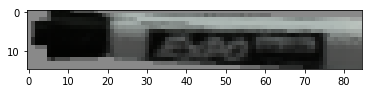

In [97]:

num_imgs=100
for i in range(num_imgs):
    contador=len(os.listdir(path+'/'+obj_name))

    x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
    eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
    spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.53,eu_i,eu_j,eu_k )
    rospy.sleep(.1)
    res = service_client(req)
    cents,xyz, images=res_to_cents(res)
    shapes_ratio=[]
   
    
    for image in images:
        print(np.abs(image.shape[0]-image.shape[1]))
        shapes_ratio.append(np.abs(image.shape[0]-image.shape[1]))
    if len(images)!=0:
        plt.imshow(images[np.argmin(shapes_ratio)])
        contador=len(os.listdir(path+'/'+obj_name))
        cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[np.argmin(shapes_ratio)], cv2.COLOR_BGR2RGB))
    
    delete_object('spawned')

('Plane', 0, 'has', 2, 'objects')
('Plane', 1, 'has', 1, 'objects')
[array([-0.2772519 ,  0.23893867,  0.84951975]), array([0.10626701, 0.34888642, 0.86449317]), array([0.10603612, 0.09624477, 0.81212775])]


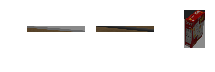

In [87]:

res = service_client(req)
cents,xyz, images=res_to_cents(res,plt_images=True)
#static_tf_publish(cents)
#move_base(1.1,1.3,np.pi)

('i am at', [1.318575355232499, 0.9826928476596752, 1.0174952022954153], 179.4236909816111)
('gaze goal', 1.25, 1.71, 0.6)
('relative to robot', (0.06857535523249902, -0.7273071523403247, -84.61369656486625))
[INFO] [1639488917.524395, 11938.304000]: Spawn: ycb_050_medium_clamp
[INFO] [1639488917.530843, 11938.304000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1639488917.535936, 11938.304000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639488917.550398, 11938.305000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639488917.722470, 11938.308000]: Spawn status: SpawnModel: Successfully spawned entity
[INFO] [1639488917.723744, 11938.308000]: Spawn: ycb_050_medium_clamp
[INFO] [1639488917.725258, 11938.308000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1639488917.726841, 11938.308000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639488917.729362, 11938.308000]: Calling service /gazebo/spawn_sdf_mod

[INFO] [1639489089.807754, 11949.809000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 2, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.06964279, 0.160888  , 0.85390768]), array([0.18209645, 0.23106773, 0.8586441 ])]
14
60
[INFO] [1639489104.421798, 11950.807000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489104.425359, 11950.807000]: Spawn: [0.         0.         0.97591745 0.21814016]
[INFO] [1639489104.427136, 11950.807000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639489104.434201, 11950.807000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639489104.776477, 11950.826000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 3, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07068794, 0.1627423 , 0.85985783]), array([0.18301636, 0.22342945, 0.87183917]), array([0.18235043, 0.23484171, 0.8521607 ])]
30
74
67
[INFO] [1639489118.948274, 11951.796000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489118.951893, 

[INFO] [1639489301.459455, 11963.901000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489301.461749, 11963.901000]: Spawn: [0.         0.         0.91140438 0.41151191]
[INFO] [1639489301.464460, 11963.902000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639489301.474439, 11963.902000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639489301.611187, 11963.903000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07265869, 0.14940001, 0.87428821])]
10
[INFO] [1639489316.985377, 11964.950000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489316.989583, 11964.951000]: Spawn: [0.         0.         0.90482818 0.4257769 ]
[INFO] [1639489316.991572, 11964.951000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639489317.002252, 11964.952000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639489317.153357, 11964.954000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'o

[INFO] [1639489529.901986, 11979.127000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489529.904430, 11979.127000]: Spawn: [0.         0.         0.79015632 0.61290537]
[INFO] [1639489529.906003, 11979.127000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639489529.909486, 11979.127000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639489530.060066, 11979.130000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07789728, 0.14360202, 0.87944277])]
21
[INFO] [1639489544.908067, 11980.115000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489544.911245, 11980.115000]: Spawn: [0.         0.         0.78043172 0.62524102]
[INFO] [1639489544.913030, 11980.115000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639489544.924229, 11980.116000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639489545.066874, 11980.116000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'o

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.085873  , 0.14155118, 0.882685  ])]
25
[INFO] [1639489770.221151, 11995.259000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489770.223519, 11995.259000]: Spawn: [0.         0.         0.61290827 0.79015407]
[INFO] [1639489770.224947, 11995.259000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639489770.230190, 11995.260000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639489770.371692, 11995.261000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08652896, 0.14153699, 0.88248421])]
24
[INFO] [1639489785.415426, 11996.277000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489785.418630, 11996.277000]: Spawn: [0.         0.         0.60042143 0.79968375]
[INFO] [1639489785.421415, 11996.278000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639489785.430899, 11996.278000]: Calling service /gazebo/spawn_sdf_model
[INF

[INFO] [1639489998.323190, 12010.422000]: Spawn: ycb_050_medium_clamp
[INFO] [1639489998.326341, 12010.422000]: Spawn: [0.         0.         0.41151526 0.91140287]
[INFO] [1639489998.328036, 12010.422000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639489998.331161, 12010.422000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639489998.659089, 12010.438000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09410725, 0.14121707, 0.8822009 ])]
18
[INFO] [1639490013.105922, 12011.426000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490013.109163, 12011.426000]: Spawn: [0.         0.         0.39714877 0.91775425]
[INFO] [1639490013.112033, 12011.427000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639490013.115382, 12011.427000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639490013.298229, 12011.430000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'o

('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639490229.255169, 12026.545000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490229.257564, 12026.545000]: Spawn: [0.         0.         0.1719295  0.98510926]
[INFO] [1639490229.260297, 12026.546000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639490229.263856, 12026.546000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639490229.598763, 12026.561000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10288133, 0.14183693, 0.88006579])]
5
[INFO] [1639490244.447061, 12027.526000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490244.449421, 12027.526000]: Spawn: [0.         0.         0.15643483 0.98768828]
[INFO] [1639490244.452189, 12027.526000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639490244.457078, 12027.527000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639490244.604306, 12027.528000]: Spawn sta

[INFO] [1639490460.549636, 12041.641000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490460.552401, 12041.641000]: Spawn: [0.         0.         0.99802695 0.062787  ]
[INFO] [1639490460.555331, 12041.641000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639490460.563636, 12041.641000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639490460.734836, 12041.646000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07706514, 0.08862234, 0.81575506])]
12
[INFO] [1639490476.207262, 12042.674000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490476.209730, 12042.674000]: Spawn: [0.         0.         0.99691761 0.07845562]
[INFO] [1639490476.211483, 12042.674000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639490476.215250, 12042.674000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639490476.388925, 12042.679000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'o

[INFO] [1639490691.594555, 12056.908000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.06999675, 0.08274368, 0.82546616])]
9
[INFO] [1639490706.483026, 12057.883000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490706.485949, 12057.883000]: Spawn: [0.         0.         0.95105742 0.3090142 ]
[INFO] [1639490706.487534, 12057.883000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639490706.494595, 12057.884000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639490706.811808, 12057.902000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.06963703, 0.08226202, 0.82615253])]
10
[INFO] [1639490721.866247, 12058.894000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490721.868826, 12058.895000]: Spawn: [0.         0.         0.9460863  0.32391467]
[INFO] [1639490721.870357, 12058.895000]: Waiting for service /gazebo/spawn_s

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07255388, 0.07656468, 0.83536745])]
23
[INFO] [1639490934.467834, 12072.976000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490934.471036, 12072.976000]: Spawn: [0.         0.         0.85264141 0.52249653]
[INFO] [1639490934.472946, 12072.977000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639490934.475991, 12072.977000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639490934.798134, 12072.995000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07286675, 0.07630166, 0.835709  ])]
24
[INFO] [1639490949.855898, 12073.969000]: Spawn: ycb_050_medium_clamp
[INFO] [1639490949.858232, 12073.969000]: Spawn: [0.         0.         0.84432919 0.53582481]
[INFO] [1639490949.859731, 12073.969000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639490949.862807, 12073.969000]: Calling service /gazebo/spawn_sdf_model
[INF

[INFO] [1639491166.787942, 12088.066000]: Spawn: ycb_050_medium_clamp
[INFO] [1639491166.790144, 12088.066000]: Spawn: [0.         0.         0.70710808 0.70710548]
[INFO] [1639491166.792039, 12088.066000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639491166.798062, 12088.066000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639491167.127699, 12088.080000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08048687, 0.07343985, 0.84088211])]
23
[INFO] [1639491183.169505, 12089.083000]: Spawn: ycb_050_medium_clamp
[INFO] [1639491183.171968, 12089.083000]: Spawn: [0.         0.         0.69591409 0.71812505]
[INFO] [1639491183.173354, 12089.083000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639491183.186164, 12089.084000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639491183.358874, 12089.087000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'o

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08843488, 0.07256886, 0.84204305])]
27
[INFO] [1639491413.195353, 12104.265000]: Spawn: ycb_050_medium_clamp
[INFO] [1639491413.198804, 12104.265000]: Spawn: [0.         0.         0.50904249 0.86074139]
[INFO] [1639491413.200563, 12104.265000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639491413.209288, 12104.266000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639491413.469822, 12104.279000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08867665, 0.07249563, 0.84210603])]
28
[INFO] [1639491428.102269, 12105.223000]: Spawn: ycb_050_medium_clamp
[INFO] [1639491428.104965, 12105.223000]: Spawn: [0.         0.         0.49545972 0.86863091]
[INFO] [1639491428.107118, 12105.223000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639491428.114135, 12105.224000]: Calling service /gazebo/spawn_sdf_model
[INF

[INFO] [1639491643.790625, 12119.343000]: Spawn: ycb_050_medium_clamp
[INFO] [1639491643.793283, 12119.343000]: Spawn: [0.         0.         0.29404099 0.95579281]
[INFO] [1639491643.794908, 12119.344000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639491643.802096, 12119.344000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639491643.957362, 12119.347000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09612217, 0.07289223, 0.84023284])]
16
[INFO] [1639491659.983187, 12120.369000]: Spawn: ycb_050_medium_clamp
[INFO] [1639491659.986367, 12120.369000]: Spawn: [0.         0.         0.27899174 0.9602935 ]
[INFO] [1639491659.987924, 12120.369000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639491659.992713, 12120.369000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639491660.147314, 12120.371000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'o

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10547718, 0.07395592, 0.83808077])]
8
[INFO] [1639491888.866615, 12135.603000]: Spawn: ycb_050_medium_clamp
[INFO] [1639491888.869287, 12135.603000]: Spawn: [0.         0.         0.04710656 0.99888987]
[INFO] [1639491888.871761, 12135.603000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639491888.883209, 12135.604000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639491889.233484, 12135.625000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10606401, 0.07411843, 0.83762315])]
8
[INFO] [1639491903.941689, 12136.602000]: Spawn: ycb_050_medium_clamp
[INFO] [1639491903.944728, 12136.603000]: Spawn: [0.         0.         0.03141083 0.99950656]
[INFO] [1639491903.946910, 12136.603000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639491903.970426, 12136.603000]: Calling service /gazebo/spawn_sdf_model
[INFO]

('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639492139.770972, 12153.852000]: Spawn: ycb_048_hammer
[INFO] [1639492139.773508, 12153.853000]: Spawn: [0.         0.         0.98510989 0.17192588]
[INFO] [1639492139.775182, 12153.853000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639492139.778178, 12153.853000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639492140.116781, 12153.870000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10359056, 0.130915  , 0.88874689])]
144
[INFO] [1639492154.586395, 12154.808000]: Spawn: ycb_048_hammer
[INFO] [1639492154.589111, 12154.808000]: Spawn: [0.         0.         0.98228786 0.18737814]
[INFO] [1639492154.590666, 12154.808000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639492154.593795, 12154.808000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639492154.735876, 12154.809000]: Spawn status: Spawn

[INFO] [1639492377.399879, 12169.027000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12467504, 0.13834492, 0.87636212])]
87
[INFO] [1639492392.961858, 12170.039000]: Spawn: ycb_048_hammer
[INFO] [1639492392.964390, 12170.039000]: Spawn: [0.         0.         0.91140438 0.41151191]
[INFO] [1639492392.967415, 12170.039000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639492392.974039, 12170.040000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639492393.154048, 12170.043000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12575081, 0.1392058 , 0.87499897])]
82
[INFO] [1639492408.570650, 12171.055000]: Spawn: ycb_048_hammer
[INFO] [1639492408.573582, 12171.055000]: Spawn: [0.         0.         0.90482818 0.4257769 ]
[INFO] [1639492408.575219, 12171.055000]: Waiting for service /gazebo/spawn_sdf_model
[I

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.13386883, 0.14477582, 0.86402942])]
23
[INFO] [1639492627.635675, 12185.261000]: Spawn: ycb_048_hammer
[INFO] [1639492627.638363, 12185.261000]: Spawn: [0.         0.         0.79015632 0.61290537]
[INFO] [1639492627.640539, 12185.261000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639492627.658416, 12185.263000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639492627.983990, 12185.278000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.13453373, 0.1460853 , 0.86225207])]
17
[INFO] [1639492643.925060, 12186.273000]: Spawn: ycb_048_hammer
[INFO] [1639492643.929303, 12186.274000]: Spawn: [0.         0.         0.78043172 0.62524102]
[INFO] [1639492643.930870, 12186.274000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639492643.937610, 12186.274000]: Calling service /gazebo/spawn_sdf_model
[INFO] [16394926

[INFO] [1639492861.929811, 12200.391000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12791273, 0.16034397, 0.8404469 ])]
40
[INFO] [1639492877.344302, 12201.374000]: Spawn: ycb_048_hammer
[INFO] [1639492877.346997, 12201.374000]: Spawn: [0.         0.         0.61290827 0.79015407]
[INFO] [1639492877.348524, 12201.374000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639492877.360805, 12201.375000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639492877.525766, 12201.379000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12616721, 0.16604907, 0.83093994])]
42
[INFO] [1639492893.231175, 12202.378000]: Spawn: ycb_048_hammer
[INFO] [1639492893.233821, 12202.378000]: Spawn: [0.         0.         0.60042143 0.79968375]
[INFO] [1639492893.235290, 12202.378000]: Waiting for service /gazebo/spawn_sdf_model
[I

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11484262, 0.16596403, 0.82758474])]
32
[INFO] [1639493114.337215, 12216.501000]: Spawn: ycb_048_hammer
[INFO] [1639493114.340295, 12216.501000]: Spawn: [0.         0.         0.41151526 0.91140287]
[INFO] [1639493114.342695, 12216.501000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639493114.348830, 12216.502000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639493114.505775, 12216.503000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11221402, 0.16715371, 0.82661861])]
18
[INFO] [1639493131.003062, 12217.513000]: Spawn: ycb_048_hammer
[INFO] [1639493131.005868, 12217.513000]: Spawn: [0.         0.         0.39714877 0.91775425]
[INFO] [1639493131.008899, 12217.514000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639493131.012495, 12217.514000]: Calling service /gazebo/spawn_sdf_model
[INFO] [16394931

[INFO] [1639493355.364239, 12231.655000]: Spawn: ycb_048_hammer
[INFO] [1639493355.369848, 12231.656000]: Spawn: [0.         0.         0.18738175 0.98228717]
[INFO] [1639493355.373311, 12231.656000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639493355.380518, 12231.656000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639493355.667854, 12231.670000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.1010792 , 0.16549321, 0.82702314])]
75
[INFO] [1639493371.962339, 12232.683000]: Spawn: ycb_048_hammer
[INFO] [1639493371.964897, 12232.684000]: Spawn: [0.         0.         0.1719295  0.98510926]
[INFO] [1639493371.966443, 12232.684000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639493371.971524, 12232.684000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639493372.122863, 12232.686000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 0, 'objects')
('P

[INFO] [1639493593.125254, 12246.861000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08926691, 0.06210304, 0.84903406])]
163
[INFO] [1639493608.443435, 12247.803000]: Spawn: ycb_048_hammer
[INFO] [1639493608.446782, 12247.803000]: Spawn: [0.         0.         0.99802695 0.062787  ]
[INFO] [1639493608.451945, 12247.804000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639493608.466415, 12247.804000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639493608.755621, 12247.817000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09081871, 0.06204566, 0.84914177])]
164
[INFO] [1639493624.818596, 12248.817000]: Spawn: ycb_048_hammer
[INFO] [1639493624.821830, 12248.817000]: Spawn: [0.         0.         0.99691761 0.07845562]
[INFO] [1639493624.823710, 12248.818000]: Waiting for service /gazebo/spawn_sdf_model


('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11130011, 0.06466196, 0.84420841])]
138
[INFO] [1639493855.291471, 12263.033000]: Spawn: ycb_048_hammer
[INFO] [1639493855.298534, 12263.033000]: Spawn: [0.         0.         0.95579389 0.29403748]
[INFO] [1639493855.303086, 12263.034000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639493855.325880, 12263.036000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639493855.677584, 12263.055000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11222842, 0.06501371, 0.84354878])]
135
[INFO] [1639493871.591619, 12264.084000]: Spawn: ycb_048_hammer
[INFO] [1639493871.594021, 12264.084000]: Spawn: [0.         0.         0.95105742 0.3090142 ]
[INFO] [1639493871.595450, 12264.084000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639493871.598606, 12264.084000]: Calling service /gazebo/spawn_sdf_model
[INFO] [163949

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.1288821 , 0.07582207, 0.8232783 ])]
61
[INFO] [1639494106.017214, 12279.175000]: Spawn: ycb_048_hammer
[INFO] [1639494106.023506, 12279.175000]: Spawn: [0.         0.         0.85264141 0.52249653]
[INFO] [1639494106.029478, 12279.176000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639494106.039942, 12279.177000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639494106.323330, 12279.192000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.1293522 , 0.07674138, 0.82155795])]
55
[INFO] [1639494121.519907, 12280.198000]: Spawn: ycb_048_hammer
[INFO] [1639494121.522499, 12280.198000]: Spawn: [0.         0.         0.84432919 0.53582481]
[INFO] [1639494121.525179, 12280.198000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639494121.528616, 12280.198000]: Calling service /gazebo/spawn_sdf_model
[INFO] [16394941

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12980739, 0.09216371, 0.79279218])]
18
[INFO] [1639494351.492248, 12295.358000]: Spawn: ycb_048_hammer
[INFO] [1639494351.494565, 12295.358000]: Spawn: [0.         0.         0.69591409 0.71812505]
[INFO] [1639494351.497163, 12295.359000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639494351.502102, 12295.359000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639494351.797840, 12295.370000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.12983447, 0.09395187, 0.79191201])]
22
[INFO] [1639494366.303701, 12296.313000]: Spawn: ycb_048_hammer
[INFO] [1639494366.306230, 12296.313000]: Spawn: [0.         0.         0.68454839 0.72896742]
[INFO] [1639494366.308057, 12296.313000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639494366.315593, 12296.314000]: Calling service /gazebo/spawn_sdf_model
[INFO] [16394943

[INFO] [1639494589.371700, 12310.394000]: Spawn: ycb_048_hammer
[INFO] [1639494589.374398, 12310.394000]: Spawn: [0.         0.         0.50904249 0.86074139]
[INFO] [1639494589.376093, 12310.394000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639494589.379384, 12310.394000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639494589.561552, 12310.397000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11299956, 0.10517658, 0.77035496])]
29
[INFO] [1639494605.249792, 12311.415000]: Spawn: ycb_048_hammer
[INFO] [1639494605.252643, 12311.415000]: Spawn: [0.         0.         0.49545972 0.86863091]
[INFO] [1639494605.254303, 12311.416000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639494605.257496, 12311.416000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639494605.442533, 12311.420000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('P

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09374856, 0.10434549, 0.77326609])]
44
[INFO] [1639494847.028662, 12326.574000]: Spawn: ycb_048_hammer
[INFO] [1639494847.032418, 12326.575000]: Spawn: [0.         0.         0.27899174 0.9602935 ]
[INFO] [1639494847.034276, 12326.575000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639494847.038095, 12326.575000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639494847.372017, 12326.591000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09270171, 0.10405369, 0.77383898])]
50
[INFO] [1639494863.781210, 12327.601000]: Spawn: ycb_048_hammer
[INFO] [1639494863.784045, 12327.601000]: Spawn: [0.         0.         0.26387365 0.96455725]
[INFO] [1639494863.785558, 12327.601000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639494863.790869, 12327.601000]: Calling service /gazebo/spawn_sdf_model
[INFO] [16394948

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08752234, 0.09826346, 0.78454088])]
132
[INFO] [1639495103.213331, 12342.763000]: Spawn: ycb_048_hammer
[INFO] [1639495103.216254, 12342.763000]: Spawn: [0.         0.         0.03141083 0.99950656]
[INFO] [1639495103.218278, 12342.763000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639495103.222279, 12342.764000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639495103.556357, 12342.783000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08758385, 0.09794284, 0.78505984])]
137
[INFO] [1639495119.643244, 12343.795000]: Spawn: ycb_048_hammer
[INFO] [1639495119.645984, 12343.795000]: Spawn: [0.         0.         0.01570735 0.99987663]
[INFO] [1639495119.647978, 12343.795000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639495119.654017, 12343.796000]: Calling service /gazebo/spawn_sdf_model
[INFO] [163949

[INFO] [1639495351.545917, 12359.968000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07589934, 0.15000453, 0.85529435])]
90
[INFO] [1639495367.168807, 12360.949000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639495367.171469, 12360.950000]: Spawn: [0.         0.         0.98228786 0.18737814]
[INFO] [1639495367.173127, 12360.950000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639495367.177800, 12360.950000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639495367.335023, 12360.952000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07580654, 0.14977529, 0.85626347])]
96
[INFO] [1639495384.256109, 12361.981000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639495384.258603, 12361.981000]: Spawn: [0.         0.         0.97922346 0.20278417]
[INFO] [1639495384.263950, 12361.982000]: Waiting for service /gazeb

[INFO] [1639495590.343765, 12375.063000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07836815, 0.14598443, 0.86331424])]
112
[INFO] [1639495605.847686, 12376.061000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639495605.849956, 12376.061000]: Spawn: [0.         0.         0.91140438 0.41151191]
[INFO] [1639495605.851395, 12376.061000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639495605.872111, 12376.063000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639495606.022855, 12376.063000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 5, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08832468, 0.14840553, 0.86269784]), array([-0.27942729,  0.21036485,  0.89542734]), array([-0.09059009,  0.21404668,  0.88893337]), array([0.00514901, 0.21617574, 0.88513885]), array([-0.03917181,  0.23324422,  0.85553903])]
112
46
22
56
117
[INFO] [1639495623.031792, 12377.

[INFO] [1639495838.805638, 12390.308000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08418638, 0.14403309, 0.86801979])]
62
[INFO] [1639495853.936143, 12391.278000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639495853.938614, 12391.278000]: Spawn: [0.         0.         0.79015632 0.61290537]
[INFO] [1639495853.940099, 12391.278000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639495853.944556, 12391.278000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639495854.107565, 12391.280000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08471603, 0.14409678, 0.86786503])]
58
[INFO] [1639495870.595867, 12392.267000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639495870.598684, 12392.267000]: Spawn: [0.         0.         0.78043172 0.62524102]
[INFO] [1639495870.601713, 12392.268000]: Waiting for service /gazeb

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08899337, 0.14312684, 0.86816545])]
3
[INFO] [1639496101.365017, 12406.364000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639496101.367247, 12406.364000]: Spawn: [0.         0.         0.62524389 0.78042942]
[INFO] [1639496101.368824, 12406.364000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496101.383962, 12406.365000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639496101.688891, 12406.380000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08993914, 0.14405022, 0.86942554])]
8
[INFO] [1639496118.088313, 12407.375000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639496118.090571, 12407.375000]: Spawn: [0.         0.         0.61290827 0.79015407]
[INFO] [1639496118.092100, 12407.375000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496118.104721, 12407.376000]: Calling service /gazebo/spawn_sdf_mode

[INFO] [1639496342.000347, 12421.500000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639496342.002912, 12421.500000]: Spawn: [0.         0.         0.42578022 0.90482661]
[INFO] [1639496342.004460, 12421.500000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496342.018473, 12421.501000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639496342.357774, 12421.517000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09413643, 0.15114964, 0.86756316])]
76
[INFO] [1639496358.089909, 12422.491000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639496358.092616, 12422.491000]: Spawn: [0.         0.         0.41151526 0.91140287]
[INFO] [1639496358.094323, 12422.491000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496358.102275, 12422.492000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639496358.286941, 12422.496000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has

[INFO] [1639496588.989549, 12436.667000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639496588.991695, 12436.667000]: Spawn: [0.         0.         0.20278776 0.97922271]
[INFO] [1639496588.994141, 12436.667000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496588.997831, 12436.668000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639496589.333798, 12436.682000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.0945559 , 0.14814439, 0.86782944])]
28
[INFO] [1639496606.185690, 12437.703000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639496606.188244, 12437.703000]: Spawn: [0.         0.         0.18738175 0.98228717]
[INFO] [1639496606.190158, 12437.703000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496606.198670, 12437.704000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639496606.537818, 12437.721000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has

[INFO] [1639496835.227294, 12451.869000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639496835.229565, 12451.869000]: Spawn: [0.         0.         0.99950667 0.03140716]
[INFO] [1639496835.231514, 12451.869000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496835.238946, 12451.869000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639496835.387769, 12451.870000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639496847.453224, 12452.872000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639496847.456149, 12452.872000]: Spawn: [0.         0.         0.99889004 0.04710289]
[INFO] [1639496847.459180, 12452.873000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639496847.488721, 12452.875000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639496847.669462, 12452.880000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objec

[INFO] [1639497082.701677, 12466.994000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639497082.704105, 12466.994000]: Spawn: [0.         0.         0.96455822 0.26387011]
[INFO] [1639497082.705561, 12466.994000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639497082.708206, 12466.994000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639497082.870010, 12466.996000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639497095.310161, 12468.009000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639497095.314182, 12468.009000]: Spawn: [0.         0.         0.96029453 0.27898821]
[INFO] [1639497095.316491, 12468.010000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639497095.320478, 12468.010000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639497095.585191, 12468.020000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objec

[INFO] [1639497325.431290, 12482.141000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639497325.433754, 12482.141000]: Spawn: [0.         0.         0.87630788 0.48175149]
[INFO] [1639497325.435380, 12482.141000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639497325.440681, 12482.141000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639497325.778522, 12482.158000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07823228, 0.07642208, 0.82530284])]
103
[INFO] [1639497341.207164, 12483.135000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639497341.219267, 12483.137000]: Spawn: [0.         0.         0.86863273 0.49545653]
[INFO] [1639497341.221376, 12483.138000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639497341.235487, 12483.139000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639497341.528435, 12483.153000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'ha

[INFO] [1639497581.531230, 12497.339000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639497581.535377, 12497.339000]: Spawn: [0.         0.         0.73963241 0.67301107]
[INFO] [1639497581.538652, 12497.340000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639497581.564062, 12497.341000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639497581.844917, 12497.352000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.0836153 , 0.07475063, 0.82775505])]
46
[INFO] [1639497599.104248, 12498.344000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639497599.106720, 12498.344000]: Spawn: [0.         0.         0.72896993 0.68454571]
[INFO] [1639497599.109276, 12498.345000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639497599.113097, 12498.345000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639497599.278540, 12498.347000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has

[INFO] [1639497838.600375, 12512.455000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639497838.603344, 12512.455000]: Spawn: [0.         0.         0.56208453 0.82707979]
[INFO] [1639497838.605644, 12512.456000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639497838.609210, 12512.456000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639497838.927400, 12512.473000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08830993, 0.0740509 , 0.82716619])]
23
[INFO] [1639497855.609871, 12513.474000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639497855.612533, 12513.474000]: Spawn: [0.         0.         0.54902395 0.83580662]
[INFO] [1639497855.614190, 12513.474000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639497855.623924, 12513.475000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639497855.976013, 12513.492000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has

[INFO] [1639498096.247737, 12527.617000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639498096.250455, 12527.617000]: Spawn: [0.         0.         0.35347563 0.93544373]
[INFO] [1639498096.252279, 12527.617000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498096.256795, 12527.618000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498096.572613, 12527.631000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09249683, 0.07638918, 0.82794311])]
72
[INFO] [1639498114.360847, 12528.676000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639498114.364243, 12528.676000]: Spawn: [0.         0.         0.33873868 0.9408805 ]
[INFO] [1639498114.368756, 12528.676000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498114.388078, 12528.678000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498114.643627, 12528.689000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has

[INFO] [1639498343.866050, 12542.852000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09689092, 0.07469737, 0.82592786])]
2
[INFO] [1639498359.932383, 12543.799000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639498359.934919, 12543.799000]: Spawn: [0.         0.         0.10973457 0.99396093]
[INFO] [1639498359.936481, 12543.799000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498359.942170, 12543.800000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498360.138463, 12543.802000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.0969658 , 0.07494718, 0.82573451])]
8
[INFO] [1639498377.664710, 12544.823000]: Spawn: ycb_044_flat_screwdriver
[INFO] [1639498377.667651, 12544.823000]: Spawn: [0.         0.         0.09410853 0.99556194]
[INFO] [1639498377.669638, 12544.823000]: Waiting for service /gazebo/

('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639498628.179534, 12561.993000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639498628.182613, 12561.993000]: Spawn: [0.         0.         0.99396133 0.10973092]
[INFO] [1639498628.184283, 12561.993000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498628.191172, 12561.993000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498628.354119, 12561.995000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11443741, 0.14807847, 0.85511784])]
39
[INFO] [1639498645.066588, 12563.046000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639498645.069139, 12563.046000]: Spawn: [0.         0.         0.99211512 0.12532988]
[INFO] [1639498645.070446, 12563.046000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498645.073999, 12563.046000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498645.249916, 12563.0

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11123112, 0.15368907, 0.85255148])]
45
[INFO] [1639498883.911345, 12577.238000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639498883.913958, 12577.238000]: Spawn: [0.         0.         0.94088174 0.33873522]
[INFO] [1639498883.915419, 12577.238000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498883.919743, 12577.238000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639498884.235202, 12577.257000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11055807, 0.15324459, 0.85068552])]
41
[INFO] [1639498901.725074, 12578.255000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639498901.729500, 12578.256000]: Spawn: [0.         0.         0.93544503 0.3534722 ]
[INFO] [1639498901.731249, 12578.256000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639498901.734180, 12578.256000]: Calling service /gazebo/spaw

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10581397, 0.15401294, 0.84670128])]
24
[INFO] [1639499134.301922, 12592.438000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639499134.304334, 12592.438000]: Spawn: [0.         0.         0.83580863 0.54902088]
[INFO] [1639499134.305941, 12592.438000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499134.325052, 12592.439000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639499134.670990, 12592.456000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10511056, 0.15449582, 0.84675202])]
28
[INFO] [1639499152.017791, 12593.443000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639499152.020523, 12593.443000]: Spawn: [0.         0.         0.82708185 0.56208149]
[INFO] [1639499152.022182, 12593.443000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499152.026146, 12593.443000]: Calling service /gazebo/spaw

('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639499388.608796, 12607.696000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639499388.611815, 12607.697000]: Spawn: [0.         0.         0.68454839 0.72896742]
[INFO] [1639499388.613187, 12607.697000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499388.626004, 12607.698000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639499388.795757, 12607.701000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10116614, 0.15539458, 0.84536591])]
97
[INFO] [1639499404.504483, 12608.639000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639499404.508115, 12608.640000]: Spawn: [0.         0.         0.67301379 0.73962993]
[INFO] [1639499404.509600, 12608.640000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499404.513541, 12608.640000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639499404.667669, 12608.6

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09651882, 0.15647947, 0.8443615 ])]
113
[INFO] [1639499640.710372, 12622.747000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639499640.712956, 12622.747000]: Spawn: [0.         0.         0.49545972 0.86863091]
[INFO] [1639499640.714398, 12622.747000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499640.718989, 12622.747000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639499640.898862, 12622.750000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09624433, 0.15662051, 0.84456822])]
109
[INFO] [1639499658.868034, 12623.771000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639499658.871303, 12623.771000]: Spawn: [0.         0.         0.4817547  0.87630611]
[INFO] [1639499658.873475, 12623.772000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499658.876740, 12623.772000]: Calling service /gazebo/sp

[INFO] [1639499881.437482, 12636.913000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09037349, 0.15722356, 0.84386856])]
62
[INFO] [1639499897.958902, 12637.916000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639499897.961814, 12637.916000]: Spawn: [0.         0.         0.27899174 0.9602935 ]
[INFO] [1639499897.963616, 12637.916000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499897.967141, 12637.917000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639499898.138771, 12637.919000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639499910.463643, 12638.898000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639499910.466430, 12638.898000]: Spawn: [0.         0.         0.26387365 0.96455725]
[INFO] [1639499910.468577, 12638.898000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639499910.4

[INFO] [1639500136.765024, 12652.060000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07538857, 0.14900602, 0.85544815])]
7
[INFO] [1639500153.779529, 12653.062000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639500153.782300, 12653.062000]: Spawn: [0.         0.         0.04710656 0.99888987]
[INFO] [1639500153.784627, 12653.063000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639500153.791004, 12653.063000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639500154.111610, 12653.078000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07521326, 0.14865757, 0.85574288])]
10
[INFO] [1639500171.026057, 12654.097000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639500171.029114, 12654.098000]: Spawn: [0.         0.         0.03141083 0.99950656]
[INFO] [1639500171.030995, 12654.098000]: Waiting for service

[INFO] [1639500403.851816, 12667.239000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11145803, 0.08087534, 0.80963921])]
49
[INFO] [1639500421.016230, 12668.242000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639500421.018878, 12668.242000]: Spawn: [0.         0.         0.98228786 0.18737814]
[INFO] [1639500421.020629, 12668.242000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639500421.027199, 12668.243000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639500421.193281, 12668.245000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11120085, 0.08101363, 0.80906243])]
51
[INFO] [1639500438.462933, 12669.262000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639500438.465946, 12669.262000]: Spawn: [0.         0.         0.97922346 0.20278417]
[INFO] [1639500438.468064, 12669.262000]: Waiting for servic

[INFO] [1639500661.091837, 12682.426000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10687791, 0.08405611, 0.80459728])]
18
[INFO] [1639500677.683306, 12683.386000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639500677.685899, 12683.386000]: Spawn: [0.         0.         0.91140438 0.41151191]
[INFO] [1639500677.689971, 12683.387000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639500677.702356, 12683.388000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639500678.063199, 12683.404000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10644099, 0.08439479, 0.80427   ])]
14
[INFO] [1639500696.297679, 12684.404000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639500696.300479, 12684.404000]: Spawn: [0.         0.         0.90482818 0.4257769 ]
[INFO] [1639500696.304409, 12684.405000]: Waiting for servic

[INFO] [1639500925.036037, 12697.554000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10256485, 0.08595881, 0.80470936])]
53
[INFO] [1639500942.384177, 12698.572000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639500942.386867, 12698.572000]: Spawn: [0.         0.         0.79015632 0.61290537]
[INFO] [1639500942.388457, 12698.572000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639500942.391915, 12698.572000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639500942.751491, 12698.586000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10229684, 0.08605936, 0.80472284])]
59
[INFO] [1639500959.546823, 12699.571000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639500959.549330, 12699.572000]: Spawn: [0.         0.         0.78043172 0.62524102]
[INFO] [1639500959.551052, 12699.572000]: Waiting for servic

[INFO] [1639501184.865619, 12712.709000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09825031, 0.08739577, 0.80466614])]
116
[INFO] [1639501203.029776, 12713.695000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639501203.033584, 12713.695000]: Spawn: [0.         0.         0.62524389 0.78042942]
[INFO] [1639501203.036148, 12713.696000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639501203.041120, 12713.696000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639501203.214298, 12713.698000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09797133, 0.08742929, 0.80458874])]
118
[INFO] [1639501221.463698, 12714.721000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639501221.467759, 12714.721000]: Spawn: [0.         0.         0.61290827 0.79015407]
[INFO] [1639501221.470114, 12714.722000]: Waiting for serv

[INFO] [1639501451.100686, 12727.866000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09266456, 0.08838688, 0.80376529])]
105
[INFO] [1639501468.844463, 12728.860000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639501468.847074, 12728.860000]: Spawn: [0.         0.         0.42578022 0.90482661]
[INFO] [1639501468.848805, 12728.860000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639501468.853042, 12728.861000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639501469.021918, 12728.864000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09269298, 0.08854923, 0.8035717 ])]
103
[INFO] [1639501486.059121, 12729.869000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639501486.063093, 12729.870000]: Spawn: [0.         0.         0.41151526 0.91140287]
[INFO] [1639501486.064733, 12729.870000]: Waiting for serv

[INFO] [1639501711.660804, 12743.009000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08516666, 0.08827898, 0.80342157])]
46
[INFO] [1639501729.236521, 12743.995000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639501729.239323, 12743.995000]: Spawn: [0.         0.         0.20278776 0.97922271]
[INFO] [1639501729.241002, 12743.995000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639501729.247869, 12743.996000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639501729.592233, 12744.009000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08493274, 0.08840567, 0.80320392])]
42
[INFO] [1639501748.400609, 12745.072000]: Spawn: ycb_043_phillips_screwdriver
[INFO] [1639501748.403663, 12745.072000]: Spawn: [0.         0.         0.18738175 0.98228717]
[INFO] [1639501748.405627, 12745.072000]: Waiting for servic

('Plane', 0, 'has', 0, 'objects')
('Plane', 1, 'has', 0, 'objects')
[]
[INFO] [1639502024.693350, 12762.739000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639502024.697101, 12762.740000]: Spawn: [0.         0.         0.99987669 0.01570368]
[INFO] [1639502024.698828, 12762.740000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639502024.710152, 12762.740000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639502024.863199, 12762.741000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.06629206, 0.15807116, 0.87634413])]
74
[INFO] [1639502034.699327, 12763.269000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639502034.702276, 12763.269000]: Spawn: [0.         0.         0.99950667 0.03140716]
[INFO] [1639502034.704104, 12763.269000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639502034.710917, 12763.269000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639502034.880478, 12763.271000]

[INFO] [1639502278.877664, 12777.466000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639502278.881215, 12777.467000]: Spawn: [0.         0.         0.96858393 0.2486869 ]
[INFO] [1639502278.882864, 12777.467000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639502278.885803, 12777.467000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639502279.216026, 12777.483000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07467593, 0.15173835, 0.88630128])]
99
[INFO] [1639502297.245068, 12778.469000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639502297.247304, 12778.469000]: Spawn: [0.         0.         0.96455822 0.26387011]
[INFO] [1639502297.248625, 12778.469000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639502297.251634, 12778.469000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639502297.440073, 12778.471000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'h

[INFO] [1639502543.815911, 12792.583000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639502543.818896, 12792.583000]: Spawn: [0.         0.         0.88376682 0.46792757]
[INFO] [1639502543.820528, 12792.583000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639502543.826613, 12792.583000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639502544.175061, 12792.599000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.0877078 , 0.14970533, 0.89080811])]
63
[INFO] [1639502561.317425, 12793.586000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639502561.320158, 12793.586000]: Spawn: [0.         0.         0.87630788 0.48175149]
[INFO] [1639502561.322166, 12793.586000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639502561.330141, 12793.587000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639502561.661908, 12793.603000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'h

[INFO] [1639502814.310611, 12807.742000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639502814.313825, 12807.743000]: Spawn: [0.         0.         0.75011238 0.66131038]
[INFO] [1639502814.315681, 12807.743000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639502814.322678, 12807.743000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639502814.664063, 12807.757000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09904337, 0.15121156, 0.8901005 ])]
12
[INFO] [1639502832.491210, 12808.764000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639502832.494049, 12808.764000]: Spawn: [0.         0.         0.73963241 0.67301107]
[INFO] [1639502832.496087, 12808.764000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639502832.503471, 12808.765000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639502832.863103, 12808.782000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'h

[INFO] [1639503082.554862, 12822.944000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639503082.557932, 12822.944000]: Spawn: [0.         0.         0.57500642 0.81814889]
[INFO] [1639503082.559575, 12822.944000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639503082.562976, 12822.944000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639503082.871452, 12822.960000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10600117, 0.15730644, 0.88638941])]
42
[INFO] [1639503100.223825, 12823.965000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639503100.226980, 12823.965000]: Spawn: [0.         0.         0.56208453 0.82707979]
[INFO] [1639503100.229322, 12823.965000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639503100.234293, 12823.966000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639503100.581613, 12823.980000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'h

[INFO] [1639503355.370045, 12838.219000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639503355.373444, 12838.219000]: Spawn: [0.         0.         0.36812537 0.92977616]
[INFO] [1639503355.375359, 12838.219000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639503355.384689, 12838.220000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639503355.546843, 12838.221000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10896599, 0.16027914, 0.88226708])]
25
[INFO] [1639503374.497923, 12839.243000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639503374.501514, 12839.244000]: Spawn: [0.         0.         0.35347563 0.93544373]
[INFO] [1639503374.503466, 12839.244000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639503374.506951, 12839.244000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639503374.843761, 12839.259000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'h

[INFO] [1639503624.978660, 12853.368000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639503624.981842, 12853.368000]: Spawn: [0.         0.         0.14090156 0.99002361]
[INFO] [1639503624.983841, 12853.368000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639503624.992029, 12853.369000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639503625.157628, 12853.370000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11232183, 0.15924228, 0.87508752])]
36
[INFO] [1639503643.856973, 12854.402000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639503643.860035, 12854.402000]: Spawn: [0.         0.         0.12533353 0.99211466]
[INFO] [1639503643.861885, 12854.402000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639503643.873611, 12854.403000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639503644.247547, 12854.419000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'h

[INFO] [1639503888.126496, 12868.607000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.06619171, 0.08657585, 0.8389901 ])]
97
[INFO] [1639503905.572314, 12869.633000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639503905.576344, 12869.634000]: Spawn: [0.         0.         0.99396133 0.10973092]
[INFO] [1639503905.578634, 12869.634000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639503905.585892, 12869.634000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639503905.759740, 12869.636000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.06676102, 0.08614461, 0.83976521])]
99
[INFO] [1639503924.656177, 12870.653000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639503924.659448, 12870.653000]: Spawn: [0.         0.         0.99211512 0.12532988]
[INFO] [1639503924.661295, 12870.653000]: Waiting for service /gaz

[INFO] [1639504160.736101, 12883.882000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07656003, 0.08151716, 0.84818772])]
98
[INFO] [1639504177.601787, 12884.822000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639504177.604376, 12884.822000]: Spawn: [0.         0.         0.94088174 0.33873522]
[INFO] [1639504177.606464, 12884.822000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639504177.610361, 12884.823000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639504177.965847, 12884.838000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.07738291, 0.08130605, 0.84857604])]
94
[INFO] [1639504195.434919, 12885.859000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639504195.438680, 12885.859000]: Spawn: [0.         0.         0.93544503 0.3534722 ]
[INFO] [1639504195.440935, 12885.859000]: Waiting for service /gaz

[INFO] [1639504430.034949, 12898.969000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.08901779, 0.08035884, 0.85045233])]
56
[INFO] [1639504447.099129, 12899.948000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639504447.101830, 12899.948000]: Spawn: [0.         0.         0.83580863 0.54902088]
[INFO] [1639504447.103896, 12899.948000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639504447.107545, 12899.949000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639504447.292756, 12899.952000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.0891828 , 0.08012499, 0.85080971])]
53
[INFO] [1639504466.609952, 12900.986000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639504466.612634, 12900.986000]: Spawn: [0.         0.         0.82708185 0.56208149]
[INFO] [1639504466.615016, 12900.986000]: Waiting for service /gaz

[INFO] [1639504707.388091, 12914.183000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.0986435 , 0.08167105, 0.84817156])]
1
[INFO] [1639504724.212751, 12915.164000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639504724.215482, 12915.165000]: Spawn: [0.         0.         0.68454839 0.72896742]
[INFO] [1639504724.217260, 12915.165000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639504724.226060, 12915.165000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639504724.420692, 12915.168000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.09921192, 0.08179425, 0.84792016])]
3
[INFO] [1639504741.995363, 12916.167000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639504741.998154, 12916.168000]: Spawn: [0.         0.         0.67301379 0.73962993]
[INFO] [1639504741.999822, 12916.168000]: Waiting for service /gazeb

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10520741, 0.08447737, 0.84310575])]
45
[INFO] [1639504993.338241, 12930.361000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639504993.340634, 12930.361000]: Spawn: [0.         0.         0.49545972 0.86863091]
[INFO] [1639504993.342353, 12930.361000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639504993.349051, 12930.361000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639504993.692249, 12930.377000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10561807, 0.08459604, 0.84327992])]
45
[INFO] [1639505010.296816, 12931.348000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639505010.299257, 12931.348000]: Spawn: [0.         0.         0.4817547  0.87630611]
[INFO] [1639505010.301929, 12931.348000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639505010.306227, 12931.349000]: Calling service /gazebo/spawn_sdf_

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.10934663, 0.08747051, 0.83789738])]
0
[INFO] [1639505255.586853, 12945.507000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639505255.589686, 12945.507000]: Spawn: [0.         0.         0.27899174 0.9602935 ]
[INFO] [1639505255.591654, 12945.507000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639505255.596392, 12945.508000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639505255.788643, 12945.510000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.1096467 , 0.08754386, 0.83770254])]
4
[INFO] [1639505274.500615, 12946.535000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639505274.504023, 12946.535000]: Spawn: [0.         0.         0.26387365 0.96455725]
[INFO] [1639505274.506172, 12946.535000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639505274.510672, 12946.535000]: Calling service /gazebo/spawn_sdf_mo

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.11198748, 0.09100373, 0.83168076])]
62
[INFO] [1639505527.296983, 12960.673000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639505527.299626, 12960.673000]: Spawn: [0.         0.         0.04710656 0.99888987]
[INFO] [1639505527.301247, 12960.673000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639505527.308022, 12960.674000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639505527.477817, 12960.675000]: Spawn status: SpawnModel: Successfully spawned entity
('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
[array([0.1124103 , 0.09116702, 0.8313643 ])]
65
[INFO] [1639505546.784893, 12961.711000]: Spawn: ycb_042_adjustable_wrench
[INFO] [1639505546.787324, 12961.711000]: Spawn: [0.         0.         0.03141083 0.99950656]
[INFO] [1639505546.788914, 12961.711000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639505546.794357, 12961.711000]: Calling service /gazebo/spawn_sdf_

KeyboardInterrupt: 

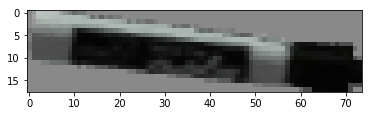

In [84]:
for ii in range (10):    
    obj_ind= -ii-40
    obj_name = ''.join(objs[obj_ind].split('_')[1:])
    obj_name
    try: 
        os.mkdir(path+obj_name) 
    except OSError as error: 
        print(error)  
    delete_object('spawned')
    move_base(1.25,1.0,np.pi)
    gaze_point(1.25,1.71,.6)
    x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
    eu_i,eu_j,eu_k = 3.1416  ,0,0
    spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.41,eu_i,eu_j,eu_k )

    num_imgs=100
    for i in range(num_imgs):
        contador=len(os.listdir(path+'/'+obj_name))

        x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
        eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
        spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.45,eu_i,eu_j,eu_k )
        rospy.sleep(.1)
        res = service_client(req)
        cents,xyz, images=res_to_cents(res)
        shapes_ratio=[]

        for image in images:
            print(np.abs(image.shape[0]-image.shape[1]))
            shapes_ratio.append(np.abs(image.shape[0]-image.shape[1]))
        if len (images)!=0:
            plt.imshow(images[np.argmin(shapes_ratio)])
            contador=len(os.listdir(path+'/'+obj_name))
            cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[np.argmin(shapes_ratio)], cv2.COLOR_BGR2RGB))

        delete_object('spawned')
    num_imgs=100
    for i in range(num_imgs):
        contador=len(os.listdir(path+'/'+obj_name))

        x_gaz,y_gaz= world_2_gazebo(1.25,1.71)
        eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
        spawn_object('spawned',objs[obj_ind], x_gaz,  y_gaz,  0.53,eu_i,eu_j,eu_k )
        rospy.sleep(.1)
        res = service_client(req)
        cents,xyz, images=res_to_cents(res)
        shapes_ratio=[]


        for image in images:
            print(np.abs(image.shape[0]-image.shape[1]))
            shapes_ratio.append(np.abs(image.shape[0]-image.shape[1]))
        if len(images)!=0:
            plt.imshow(images[np.argmin(shapes_ratio)])
            contador=len(os.listdir(path+'/'+obj_name))
            cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[np.argmin(shapes_ratio)], cv2.COLOR_BGR2RGB))

        delete_object('spawned')

In [83]:
ii

9

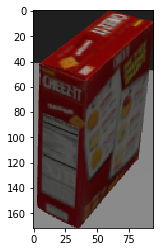

In [89]:
plt.imshow(images[np.argmin(shapes_ratio)])
contador=len(os.listdir(path+'/'+obj_name))
cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[np.argmin(shapes_ratio)], cv2.COLOR_BGR2RGB))
delete_object('spawned')

('cX,cY', 147, 465)
[-0.2088794   0.45378765  1.1423471 ]
('cX,cY', 632, 463)
[0.671188   0.47392997 1.1998048 ]
('cX,cY', 300, 429)
[-0.08252022  0.3785833   1.1001376 ]
('cX,cY', 388, 302)
[0.11613703 0.10026138 0.9211477 ]
('cX,cY', 370, 120)
[ 0.36192173 -0.72074103  3.268955  ]
('cX,cY', 385, 42)
[ 0.41858223 -1.3087462   3.7992365 ]
('cX,cY', 26, 51)
[-1.6434754 -1.0098072  3.1469066]


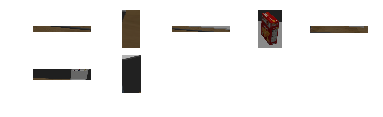

In [84]:
#cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)


In [85]:
ii

5

In [65]:
arm.set_named_target('go')
arm.go()
head.set_named_targeta('neutral')
head.go()

AttributeError: 'MoveGroupCommander' object has no attribute 'set_named_targeta'

In [108]:
path='/home/oscar/Videos/videos_to_keras_train/'

objs[15].split('_')[1:]
obj_name = ''.join(objs[15].split('_')[1:])
obj_name
try: 
    os.mkdir(path+obj_name) 
except OSError as error: 
    print(error)  


[Errno 17] File exists: '/home/oscar/Videos/videos_to_keras_train/002masterchefcan'


True

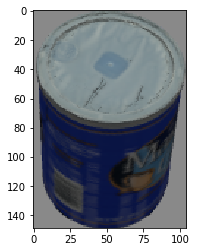

In [110]:
plt.imshow(images[0])
contador=len(os.listdir(path+'/'+obj_name))

cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))

In [77]:

def pad_digit_num(num,length):
    text_num=''
    for i in range(length -len(str(num))):
        text_num=text_num+'0'
    return(text_num+str(num))


In [79]:
contador=len(os.listdir(path+'/'+obj_name))
x_gaz,y_gaz= world_2_gazebo(1.5,1.61)
eu_i,eu_j,eu_k = 2,0.0,0.0
spawn_object('spawned',objs[15], x_gaz,  y_gaz,  0.51,eu_i,eu_j,eu_k )

cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))
delete_object('spawned')

[INFO] [1639176405.867521, 382.221000]: Spawn: ycb_002_master_chef_can
[INFO] [1639176405.871339, 382.221000]: Spawn: [0.         0.         0.84147098 0.54030231]
[INFO] [1639176405.877488, 382.221000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1639176405.892504, 382.235000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1639176406.261470, 382.287000]: Spawn status: SpawnModel: Successfully spawned entity


[array([-0.48997826,  0.47688341, -0.33030321,  0.65069448]),
 array([-0.16005207, -0.64494008, -0.18783798,  0.72329283]),
 array([-0.40752737,  0.91122733, -0.05654474,  0.01972043])]

In [26]:
#cents, xyz=seg_pca()
#quats= pca_xyz(xyz)

cents= objs_depth_centroids
static_tf_publish(cents,quats)

NameError: name 'objs_depth_centroids' is not defined

In [76]:
centroids,xyz, images=seg_pca()
quats= pca_xyz(xyz)
static_tf_publish(centroids,quats)

('cX,cY', 73, 470)
[-0.38657558  0.40541616  0.98836577]
('cX,cY', 208, 439)
[-0.20475249  0.3305767   0.910819  ]
('cX,cY', 545, 430)
[0.46011162 0.37007445 1.1287674 ]
('cX,cY', 318, 326)
[-0.00164222  0.09490793  0.608489  ]
('cX,cY', 344, 50)
[ 0.15221651 -1.0081769   2.898817  ]
('cX,cY', 520, 9)
[ 1.2383422 -1.4023637  3.4012706]
('images[]', 0)
('images[]', 1)
('images[]', 2)
('images[]', 4)
('images[]', 5)


True

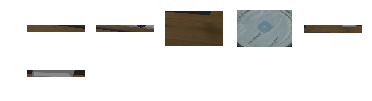

In [77]:
sub_plt=0
for image in images:
    
    sub_plt+=1
    ax = plt.subplot(5, 5, sub_plt )
    
    plt.imshow(image)
    plt.axis("off")

        

In [113]:
delete_object('spawned')

In [ ]:
tf.transformations.quaternion_from_euler(eu_i,eu_j,eu_k)

In [67]:
gaze_point( 1.45,1.7,  0.51)
arm.set_named_target('go')
arm.go()

('i am at', [1.504013154042386, 1.0881122082471295, 0.9671971453120808], 91.18959144177308)
('gaze goal', 1.45, 1.7, 0.51)
('relative to robot', (0.05401315404238605, -0.6118877917528704, -84.95540681911935))


True

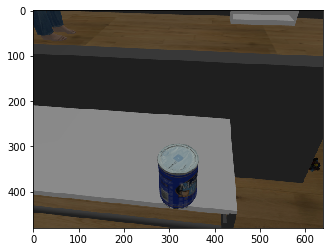

In [68]:
plt.imshow (rgbd.get_image())

('cX,cY', 76, 470)
[-0.3889382   0.40851146  0.9961041 ]
('cX,cY', 208, 438)
[-0.20423812  0.32901195  0.9134121 ]
('cX,cY', 545, 430)
[0.46086848 0.36852357 1.1306168 ]
('cX,cY', 319, 325)
[-5.3649477e-04  9.3556471e-02  6.1028546e-01]
('cX,cY', 302, 237)
[0.02285562 0.02727817 0.94996685]
('cX,cY', 343, 50)
[ 0.15232696 -1.0072949   2.8953772 ]
('cX,cY', 518, 8)
[ 1.2572143 -1.4013929  3.398889 ]


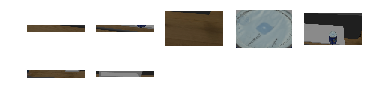

In [70]:
cents,xyz,images=seg_pca(lower=1000,higher=500000,plt_images=True)

In [71]:
res = service_client(req)

('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
('Plane', 2, 'has', 1, 'objects')
('Plane', 3, 'has', 0, 'objects')
[array([3.56465416e-05, 1.00570345e-01, 6.18601648e-01]), array([-0.14591429,  0.28734213,  0.73829112])]


(array([[ 3.56465416e-05,  1.00570345e-01,  6.18601648e-01],
        [-1.45914289e-01,  2.87342130e-01,  7.38291115e-01]]),
 array([array([[-0.00875298,  0.06010379,  0.64700001],
        [-0.00641885,  0.06010379,  0.64700001],
        [-0.00873945,  0.06117615,  0.64600003],
        ...,
        [ 0.04290358,  0.20726657,  0.67000002],
        [ 0.04450717,  0.2091227 ,  0.67600006],
        [ 0.04303165,  0.20909745,  0.67200005]]),
        array([[-0.44399658,  0.26528969,  0.76800001],
        [-0.44122592,  0.26528969,  0.76800001],
        [-0.44284034,  0.26598054,  0.76600003],
        ...,
        [ 0.12097691,  0.29648745,  0.69500005],
        [ 0.12115098,  0.29816949,  0.69600004],
        [ 0.12149911,  0.30028537,  0.69800001]])], dtype=object))

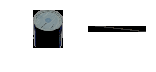

In [72]:
res_to_cents(res,plt_images=True)

In [53]:
path='/home/oscar/Videos/videos_to_keras_train/'
os.listdir(path)
objs[15].split('_')[1:]
obj_name = ''.join(objs[15].split('_')[1:])
obj_name

'002masterchefcan'

In [114]:
try: 
    os.mkdir(path+obj_name) 
except OSError as error: 
    print(error)  
cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',img_roi)

[Errno 17] File exists: '/home/oscar/Videos/videos_to_keras_train/002masterchefcan'


NameError: name 'img_roi' is not defined

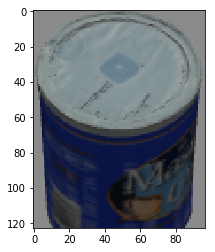

In [101]:
plt.imshow(images[0])

In [74]:
res_to_cents(res)

('Plane', 0, 'has', 3, 'objects')
('Plane', 1, 'has', 0, 'objects')
('Plane', 2, 'has', 0, 'objects')
('Plane', 3, 'has', 0, 'objects')
[array([ 0.45296013, -0.04971411,  0.96959864]), array([-4.17267404e-05,  1.00913426e-01,  6.18089280e-01]), array([-0.14664006,  0.28748951,  0.73805637])]


(array([[ 4.52960134e-01, -4.97141067e-02,  9.69598645e-01],
        [-4.17267404e-05,  1.00913426e-01,  6.18089280e-01],
        [-1.46640063e-01,  2.87489507e-01,  7.38056373e-01]]),
 array([array([[ 0.41473159, -0.07013206,  0.96000004],
        [ 0.4177593 , -0.07005901,  0.95900005],
        [ 0.41516361, -0.06847166,  0.96100003],
        ...,
        [ 0.49080631, -0.03260293,  0.97700006],
        [ 0.49130866, -0.03087218,  0.97800004],
        [ 0.49181104, -0.02913782,  0.97900003]]),
        array([[-0.00758592,  0.06010379,  0.64700001],
        [-0.00525179,  0.06010379,  0.64700001],
        [-0.00757419,  0.06117615,  0.64600003],
        ...,
        [ 0.04290358,  0.20726657,  0.67000002],
        [ 0.04450717,  0.2091227 ,  0.67600006],
        [ 0.04303165,  0.20909745,  0.67200005]]),
        array([[-0.44399658,  0.26528969,  0.76800001],
        [-0.44122592,  0.26528969,  0.76800001],
        [-0.44284034,  0.26598054,  0.76600003],
        ...,
        [ 0.1208

('Plane', 0, 'has', 3, 'objects')
('Plane', 1, 'has', 0, 'objects')
('Plane', 2, 'has', 0, 'objects')
('Plane', 3, 'has', 0, 'objects')
[array([ 0.45296013, -0.04971411,  0.96959864]), array([-4.17267404e-05,  1.00913426e-01,  6.18089280e-01]), array([-0.14664006,  0.28748951,  0.73805637])]


ValueError: need more than 2 values to unpack

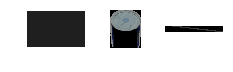

In [75]:
cents, xyz,images=res_to_cents(res,True)

In [ ]:
quats=pca_xyz(xyz)

In [ ]:
static_tf_publish(cents,quats,'end')

In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=10000,plt_images=True)

In [ ]:
move_base(2,1,np.pi)

In [ ]:
gaze_point(1,1,.1)
arm.set_named_target('go')
arm.go()

In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=10000,plt_images=True)

In [ ]:
x_gaz,y_gaz= world_2_gazebo(1,1)
eu_i,eu_j,eu_k = .5*np.pi,0,0
spawn_object('spawned',objs[-13], x_gaz,  y_gaz,  0.6,eu_i,eu_j,eu_k )


In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)
quats=pca_xyz(xyz)
static_tf_publish(cents,quats,'at 2,1')

In [ ]:
move_base(1.5,.5,np.pi)

In [ ]:
gaze_point(1,1,.1)
arm.set_named_target('go')
arm.go()

In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)
quats=pca_xyz(xyz)
static_tf_publish(cents,quats,'at 1.5,.5')

In [ ]:
move_base(1.5,.5,0)

In [ ]:
gaze_point(1,1,.1)
arm.set_named_target('go')
arm.go()

('cX,cY', 301, 476)
[-0.00747844  0.21911964  0.5158296 ]
('cX,cY', 75, 468)
[-0.35996425  0.37436187  0.92190623]
('cX,cY', 290, 444)
[-0.16598909  0.35188416  0.93478006]
('cX,cY', 443, 285)
[0.14822534 0.00063732 0.6164476 ]
('cX,cY', 411, 326)
nan
('cX,cY', 454, 232)


/home/oscar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice.
/home/oscar/.local/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[ 0.20696914 -0.04515864  0.6708069 ]
('cX,cY', 613, 1)
[ 1.4960889 -1.2877432  3.0058494]
('cX,cY', 105, 3)
[-1.0369995 -1.1491358  2.699405 ]
('cX,cY', 17, 5)
[-1.5290263 -1.1761056  2.8287847]


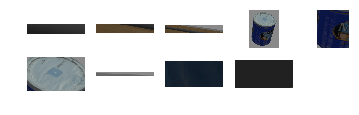

In [147]:
cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)

